### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Aditya Desu

**Student ID:**     1000447

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


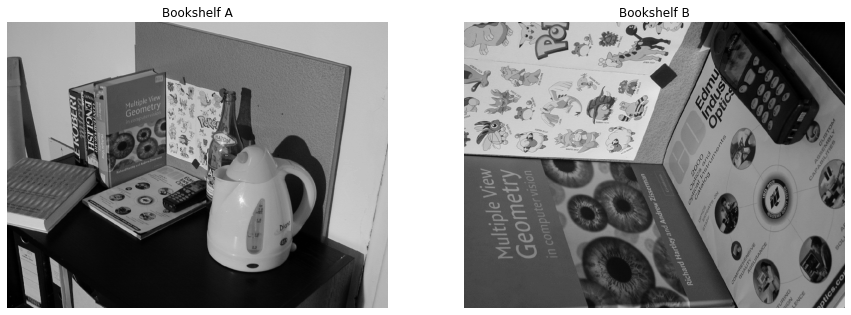

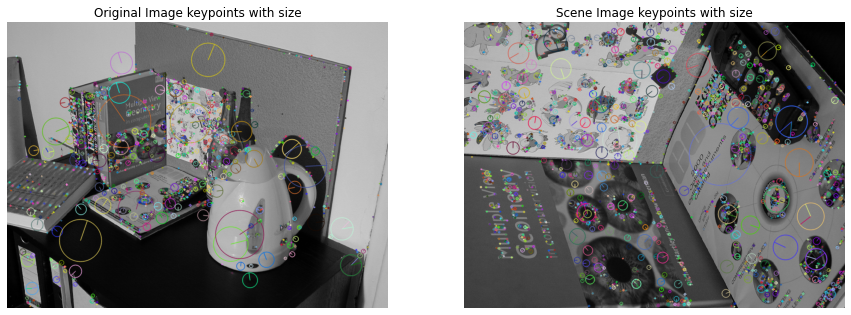

Number of keypoints detected in the Scene image:  2182
[ 52 467] [360  30]
[ 99 238] [466 125]
[209 284] [410 560]
[212 353] [610 548]
[212 357] [627 546]
[214 297] [444 547]
[216 286] [414 542]
[217 355] [618 532]
Number of matches:  156
[[ 52. 467.   1.]
 [ 99. 238.   1.]
 [209. 284.   1.]]


In [82]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
# Load images
data_dir = '/Users/adityadesu/Documents/Computer Vision/Assignment 3/kusvod2'

bookshelfA = cv2.imread(os.path.join(data_dir, 'bookshA.png'), cv2.IMREAD_GRAYSCALE)
bookshelfB = cv2.imread(os.path.join(data_dir, 'bookshB.png'), cv2.IMREAD_GRAYSCALE)

# Convert to colour space
#bookshelfA = cv2.cvtColor(bookshelfA, cv2.COLOR_BGR2RGB)
#bookshelfB = cv2.cvtColor(bookshelfB, cv2.COLOR_BGR2RGB)

# Display original image and scene image
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(bookshelfA, cmap='gray') 
plt.title('Bookshelf A')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(bookshelfB, cmap='gray')
plt.title('Bookshelf B')
plt.axis('off')

plt.show() 

# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(bookshelfA,None)
kp2, des2 = sift.detectAndCompute(bookshelfB,None)

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(bookshelfA,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(bookshelfB,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplots(figsize=(15, 15)) 
plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Original Image keypoints with size')
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Scene Image keypoints with size')
plt.axis('off')
plt.show() 

print("Number of keypoints detected in the Scene image: ", len(kp2))

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7 *n.distance: 
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)



ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)


for i in range(len(ptsL)):
    print(ptsL[i], ptsR[i])
    if i == 7:
        break

print("Number of matches: ", len(ptsL))

# Add ones to the end of the points
test = np.hstack((ptsL, np.ones((ptsL.shape[0], 1))))
test2 = np.hstack((ptsR, np.ones((ptsR.shape[0], 1))))
print(test[0:3])


### 2. Compute the Fundamental Matrix F using the 8 point algorithm

(156, 3)
Best F:
 [[ 3.10154401e-05  2.29365500e-07 -5.31234283e-03]
 [ 1.08118077e-07  3.06591936e-05 -6.59439810e-03]
 [-6.68819341e-03 -2.07024240e-02  5.57538530e+00]]
Number of inliers: 88
F from inliers:
 [[ 3.08794198e-05  2.20010077e-07 -5.28115416e-03]
 [ 1.20584410e-07  3.05702083e-05 -6.52203431e-03]
 [-6.51192664e-03 -2.06300858e-02  5.49138923e+00]]


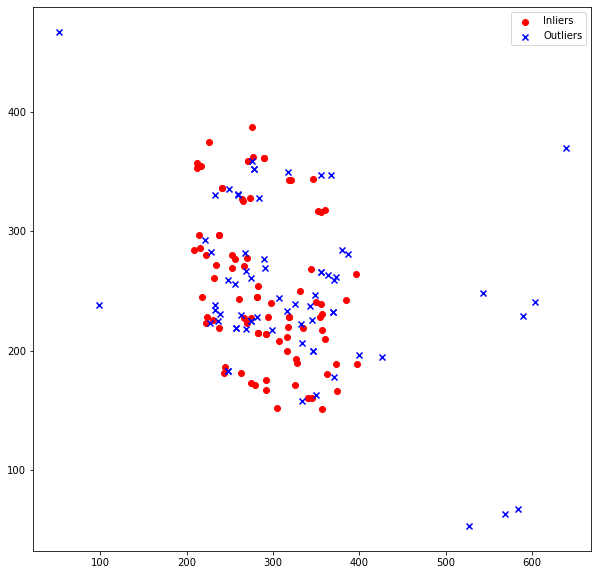

In [85]:
def normalize(pts):
    ''' Shift and transform points to have root 2 mean and unit variance '''
    n = len(pts)
    centroid = np.mean(pts, axis=0)
    centered_coords = pts - centroid
    scaling_f = n*np.sqrt(2)/np.sum(np.linalg.norm(centered_coords, axis=1))
    T = np.array([[scaling_f, 0, -scaling_f*centroid[0]], 
                [0, scaling_f, -scaling_f*centroid[1]], 
                [0, 0, 1]])
    normalised_pts = pts.copy()
    for i in range(n):
        normalised_pts[i] = T @ pts[i]
    #normalised_pts_2 = np.matmul(T, pts)
    return normalised_pts, T
normalised_pts1, T1 = normalize(test)
normalized_pts2, T2 = normalize(test2)

print(normalised_pts1.shape)

def get_design_matrix(ptsL, ptsR, idx):
    ''' Return a design matrix for the 8 point algorithm '''
    n = len(idx)
    
    
    A = np.zeros((n, 9))
    for i,x in enumerate(idx):
        design_matrix_row = np.array([ptsL[x, 0]*ptsR[x, 0], ptsL[x, 1]*ptsR[x, 0], ptsR[x, 0], 
                                    ptsL[x, 0]*ptsR[x, 1], ptsL[x, 1]*ptsR[x, 1], ptsR[x, 1], 
                                    ptsL[x, 0], ptsL[x, 1], 1])

        A[i] = design_matrix_row
        
    return A

def get_fundamental_matrix(A):
    ''' Return the fundamental matrix using the 8 point algorithm '''

    U, S, V = np.linalg.svd(A)
    F = V[-1, :].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ V
    return F


def compute_epilines(F, pts, inliers, right):
    ''' Return the epilines for a given set of F, points and inliers '''
    epilines = []
    if right:
        for i in inliers:
            x = np.array([pts[i, 0], pts[i, 1], 1])
        
            epiline = np.matmul(F, x)
            epilines.append(epiline)
        return np.array(epilines)
    else:
        for i in inliers:
            x = np.array([pts[i, 0], pts[i, 1], 1])
            epiline = np.matmul(F.T, x)
            epilines.append(epiline)
        return np.array(epilines)

# Compute inlers and outliers
def get_inliers_outliers(ptsL, ptsR, F, threshold):
    ''' Return inliers and outliers given a fundamental matrix, a threshold and a set of points '''
    inliers = []
    outliers = []
    epipolar_lines_right = []
   

    for i in range(len(ptsL)):
        x1 = np.array([ptsL[i, 0], ptsL[i, 1], 1])
        x2 = np.array([ptsR[i, 0], ptsR[i, 1], 1])
        # Compute epipolar line for both images
        epipolar_line_right = np.dot(F, x1)
        
        epipolar_lines_right.append(epipolar_line_right)
        
        
        a, b, c = epipolar_line_right

        # Compute distance from point to epipolar line
        d1 = abs(x1 @ epipolar_line_right) / np.linalg.norm(epipolar_line_right[:2])
        d2 = abs((a * x2[0] + b * x2[1] + c) / (np.sqrt(a**2 + b**2)))
        #print(d2)
        if d2 < threshold:
            inliers.append(i)
        else:
            outliers.append(i)
    
    return inliers, outliers

# A = get_design_matrix(ptsL_normalised, ptsR_normalised, [0,1,2,3,4,5,6,200])

# draft_F = get_fundamental_matrix(A)


# # Rescale the fundamental matrix
# F = T2.T @ draft_F @ T1
# print("Determinant of F after rescaling", np.linalg.det(F))
# print("Rescaled F:\n", F)

# # Compute inliers and outliers
# inliers, outliers = get_inliers_outliers(ptsL, ptsR, F, 2)
# print("Number of inliers:", len(inliers))
# print("Number of outliers:", len(outliers))

# Combine above functions within a RANSAC loop
def ransac(ptsL, ptsR, threshold, n_iterations):
    ''' Return the fundamental matrix using RANSAC '''
    best_F = None
    best_inliers = None
    best_outliers = None
    best_inliers_count = 0
    ratio = 0
    n = len(ptsL)

    for i in range(n_iterations):
        # Randomly sample 8 points
        idx = np.random.choice(n, 8, replace=False)
        
        # Compute the fundamental matrix
        ptsL_normalised, T1 = normalize(ptsL)
        ptsR_normalised, T2 = normalize(ptsR)
        A = get_design_matrix(ptsL_normalised, ptsR_normalised, idx)
        draft_F = get_fundamental_matrix(A)
        
        # Rescale the fundamental matrix
        F = T2.T @ draft_F @ T1
        
        # Compute inliers and outliers
        inliers, outliers = get_inliers_outliers(ptsL, ptsR, F, threshold)
        
        # Update best F and inliers
        if len(inliers)/len(ptsL) > ratio:
            best_F = F
            best_inliers = inliers
            ratio = len(inliers)/len(ptsL)
            best_outliers = outliers
            best_inliers_count = len(inliers)

         
        
    return best_F, best_inliers, best_outliers

# Run RANSAC
best_F, best_inliers, best_outliers = ransac(test, test2, 1, 1204)
print("Best F:\n", best_F)
print("Number of inliers:", len(best_inliers))

# Derive F from the best inliers
ptsL_normalised, T1 = normalize(test)
ptsR_normalised, T2 = normalize(test2)
A = get_design_matrix(ptsL_normalised, ptsR_normalised, best_inliers)
draft_F = get_fundamental_matrix(A)
F = T2.T @ draft_F @ T1
print("F from inliers:\n", F)



# Plot inliers and outliers
plt.figure(figsize=(10, 10))
plt.scatter(ptsL[best_inliers, 0], ptsL[best_inliers, 1], c='r', marker='o', label='Inliers')
plt.scatter(ptsL[best_outliers, 0], ptsL[best_outliers, 1], c='b', marker='x', label='Outliers')
plt.legend()
plt.show()

 


### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

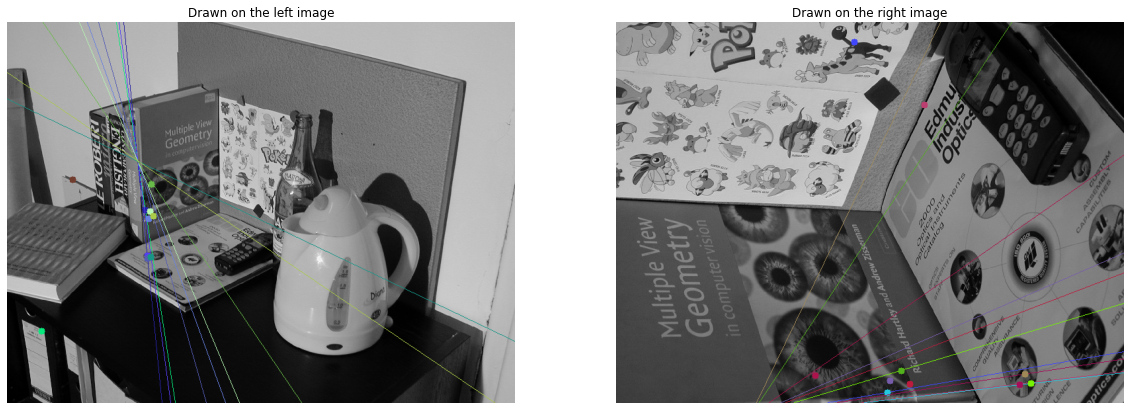

In [84]:

# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2




random_idx = np.random.choice(len(best_inliers), 8, replace=False)

linesL = compute_epilines(best_F, ptsR, best_inliers[:10], False)

linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(bookshelfA, bookshelfB, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = compute_epilines(best_F, ptsL, best_inliers[:10], True)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(bookshelfB, bookshelfA, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(20, 20)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show()

In [ ]:
Determinant of draft F before setting the smallest singular value to 0 0.01775090734658753
Determinant of draft F after setting smallest singular value to 0 -1.019700809537589e-17
Reassembled F:
 [[-0.00745451 -0.2730524  -0.29231574]
 [ 0.31491797 -0.00640091 -0.53701399]
 [ 0.33525935  0.57648981  0.07954807]]
Determinant of F after rescaling 0.0
Rescaled F:
 [[  -88.03992321 -3224.82882349 -7009.69889716]
 [ 3719.27343068   -75.59661692  8868.32845772]
 [ 7254.29329831 -7949.31638908   855.66363194]]

SyntaxError: invalid syntax (3976310919.py, line 1)

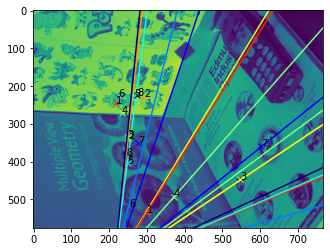

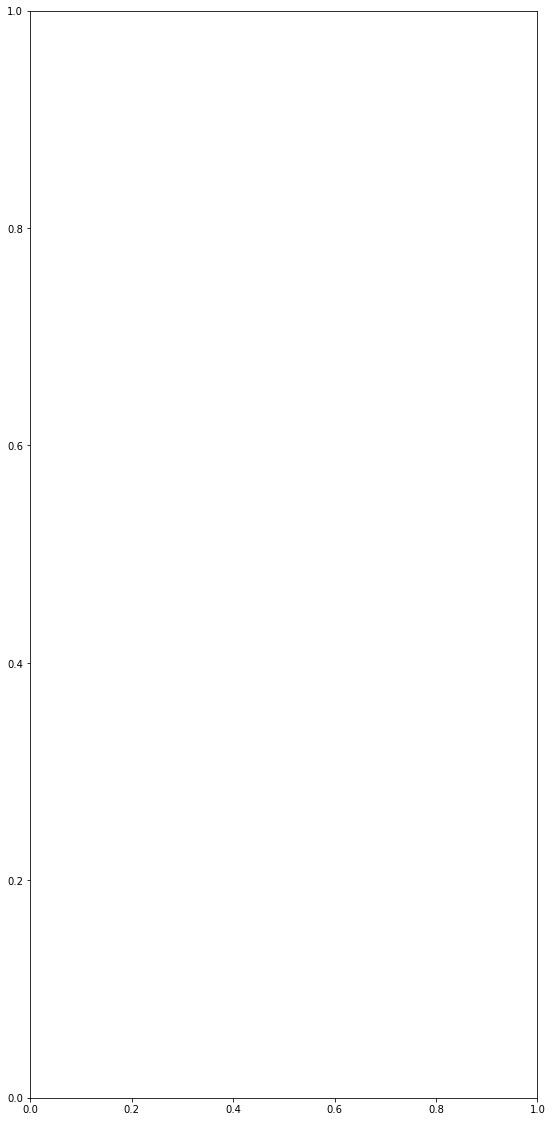

AttributeError: 'AxesImage' object has no property 'dtype'

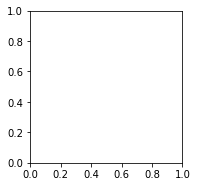

In [97]:
#%%
from numpy import dtype


cmap = plt.get_cmap("jet_r")
# plot on img1
def plot1(img, f_mat, points):
    w = img.shape[1]
    num = 1
    for x, y, *pt in points:
        color = cmap(num/len(points))
        a,b,c = np.array([x,y, 1]) @ f_mat
        p1 = (0,-c/b)
        p2 = (w, -(a*w + c)/b)
        plt.plot(*zip(p1,p2), color=color)
        plt.plot(x, y, "x",color=color)
        plt.text(x,y,f"{num}")
        num+=1
    plt.imshow(img)

#%%
# plot on img 2 
# epipolar lines based on  x'y' and points x,y
def plot2(img, f_mat, points):
    w = img.shape[1]
    num = 1
    for *pt, x,y in points:
        color = cmap(num/len(points))
        a,b,c = f_mat @ [x,y, 1]
        p1 = (0,-c/b)
        p2 = (w, -(a*w + c)/b)
        plt.plot(*zip(p1,p2), color=color)
        plt.plot(x,y, "x", color=color)
        plt.text(x,y,f"{num}")
        num+=1
    plt.imshow(img)
    
# Get indexes of random best inliers to plot
random_idx = np.random.choice(len(best_inliers), 8, replace=False)


img_1 = plot1(bookshelfA, best_F.T, ptsR[random_idx])
img_2 = plot2(bookshelfB, best_F, ptsL[random_idx])

#Plot both images side by side
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.show(img_1)
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_2,dtype=np.uint8)
plt.title('Drawn on the right image')
plt.axis('off')
plt.show()